In [2]:
# pip install ioh

from ioh import ProblemClass, get_problem

f = get_problem(22, instance=1, dimension=2, problem_class=ProblemClass.BBOB)

# Evaluate
y = f([0.0] * 2)
print("f(x) =", y)

f(x) = -936.0557554469844


(<Figure size 1850x1050 with 2 Axes>,
 <Axes3D: xlabel='$x_1$', ylabel='$x_2$', zlabel='$\\text{\\textbf{\\textcolor{red}{(inversed)}}}$ $f\\!\\br{\\bm{x}}$'>)

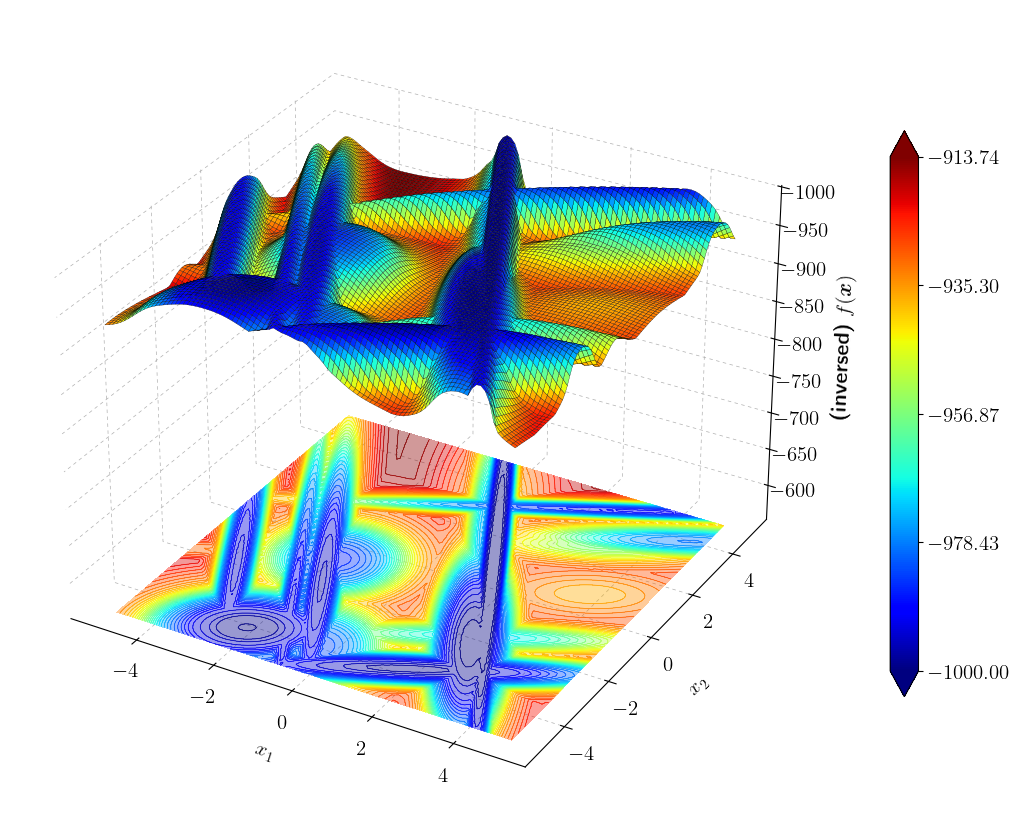

In [3]:
import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()

myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    [],
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)

In [16]:
from datetime import datetime
from importlib import reload

import FewShotCVRP.bo_pure as bo_pure

reload(bo_pure)

bo = bo_pure.BayesianOptimizer(
    f,
    f_batch=None,
    bounds=[(-5.0, 5.0), (-5.0, 5.0)],
    n_init=10,
    n_iter=20,
    sigma=0.001,
    noise_std_guess=0.5,
    noise_std_bounds=(0.1, 1.0),
    kernel="rbf",
    length_scale_bounds=(0.1, 10.0),
    c_factor_bounds=(1 / 2, 2.0),
    suggestions_per_step=3,  # 3 diverse local maxima of EI per iteration
    diversity_frac=0.1,  # 10% of average box size as min separation
    random_state=1,
)
result = bo.run()
gp = bo.get_gp()
print("Best x:", result["x_obs_best"], "Best y:", result["y_obs_best"])
print("Kernel:", gp.kernel_)
print("\nARD report:")
bo.report_ard()
now = datetime.now()
current_time = now.strftime("%Y-%m-%d-%Hh%Mm%Ss")
bo.save_snapshot(f"../outputs/bo-experiments-{current_time}", result)

Selected 1 new points
Selected 3 new points
Selected 2 new points
Selected 3 new points
Selected 3 new points
Selected 1 new points
Selected 2 new points
Selected 3 new points
Selected 2 new points
Selected 3 new points
Selected 3 new points
Selected 2 new points
Selected 3 new points
Selected 3 new points
Selected 1 new points
Selected 3 new points
Selected 3 new points
Selected 3 new points
Selected 3 new points
Selected 3 new points
Best x: [ 2.51923995 -2.38757368] Best y: -999.2299809746221
Kernel: 1.09**2 * RBF(length_scale=[0.792, 0.935])

ARD report:
feature    length_scale        1/length
---------------------------------------
x0             0.792108         1.26245
x1             0.934824         1.06972


PosixPath('../outputs/bo-experiments-2025-09-01-19h33m46s')

In [6]:
import FewShotCVRP.bo_pure as bo_pure

snap = bo_pure.BayesianOptimizer.load_snapshot(
    "../outputs/bo-experiments-2025-09-01-19h33m46s"
)

gp = snap.gp
X = snap.arrays["X_"]
y = snap.arrays["y_"]
print("Kernel:", gp.kernel_)
print("Best:", snap.result["x_obs_best"], snap.result["y_obs_best"])
mu, std = gp.predict(X[:3], return_std=True)
print("Posterior @ first 3 points:", mu, std)

Kernel: 1.09**2 * RBF(length_scale=[0.792, 0.935])
Best: [2.5192399460298383, -2.3875736836330743] -999.2299809746221
Posterior @ first 3 points: [-933.40872474 -915.43545529 -988.08262836] [0.02581439 0.02581439 0.02581427]


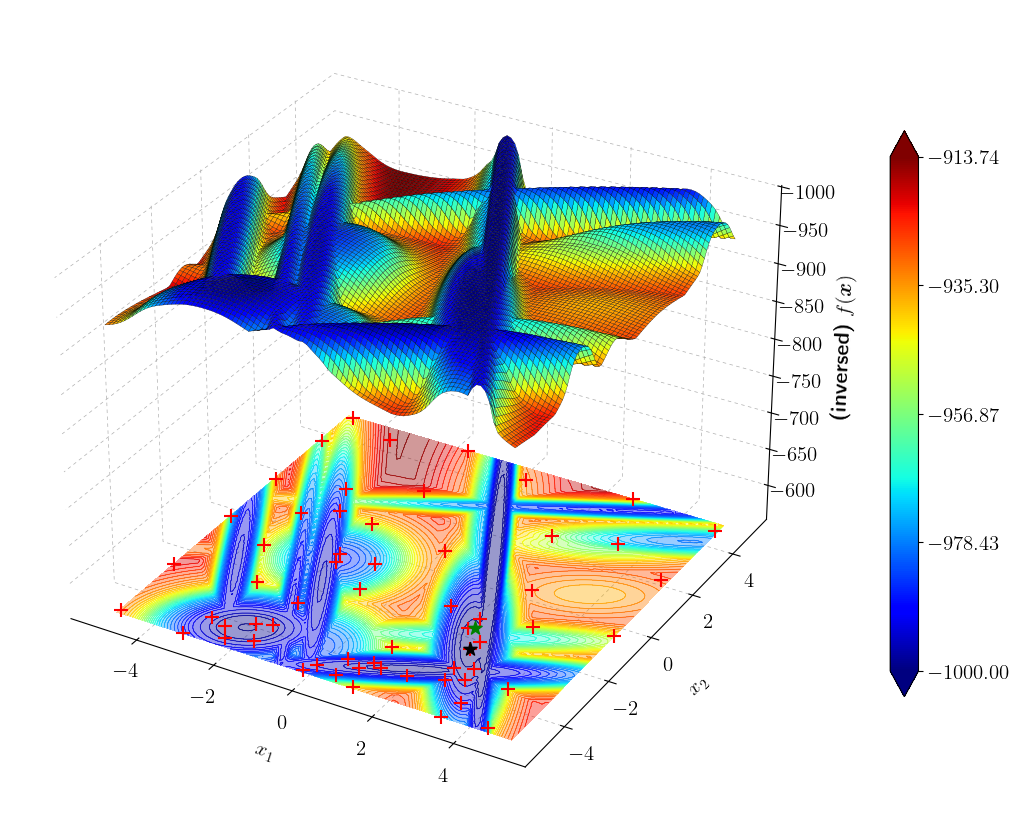

In [ ]:
fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    X,
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)

x_obs_best = snap.result["x_obs_best"]
x_rec_mean_global = snap.result["x_rec_mean_global"]
zax_min, zax_max = ax.get_zlim()
ax.scatter(
    x_obs_best[0],
    x_obs_best[1],
    zax_min,
    c="black",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
)
ax.scatter(
    x_rec_mean_global[0],
    x_rec_mean_global[1],
    zax_min,
    c="green",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
)

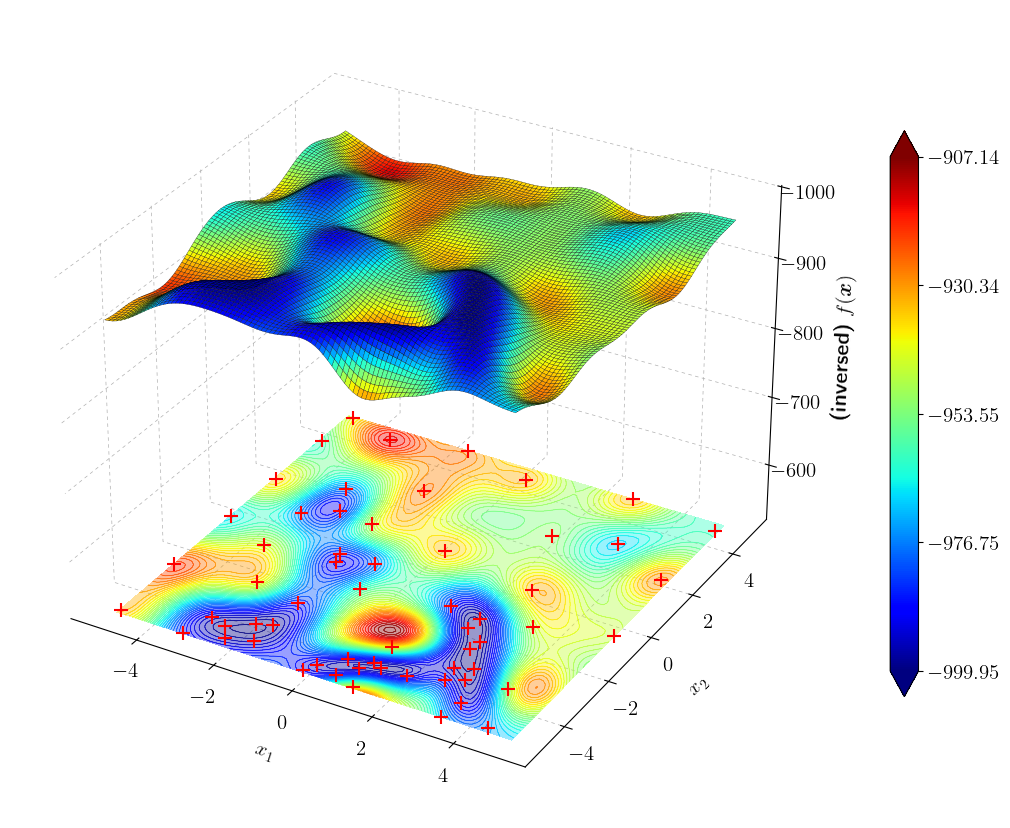

In [ ]:
fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    lambda x: gp.predict([x], return_std=False)[0],
    X,
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)

In [11]:
# pip install cma

import cma
import numpy as np
from cma.boundary_handler import BoundTransform
from cma.options_parameters import CMAOptions

dim = 2
sigma0 = 1.0
tolx = 1e-10
tolfun = 1e-10
tolfunhist = 1e-5
verb_disp = 0
verb_log = 0
seed = 42
maxevals = 30

rng = np.random.default_rng(seed)
lo, up = np.ones(dim) * -5, np.ones(dim) * 5
x0 = rng.uniform(low=lo, high=up, size=dim)
base_opts = {
    "integer_variables": None,
    "BoundaryHandler": BoundTransform,
    "bounds": [np.array(lo), np.array(up)],
    "maxfevals": maxevals,
    "tolx": tolx,
    "tolfun": tolfun,
    "tolfunhist": tolfunhist,
    "verb_disp": verb_disp,
    "verb_log": verb_log,
    "seed": seed,
}

opts = CMAOptions(base_opts)

cma_history = []


def f_(x):
    cma_history.append(x)
    return f(x)


# Construct and run
es = cma.CMAEvolutionStrategy(x0, sigma0, opts)
res = es.optimize(f_).result

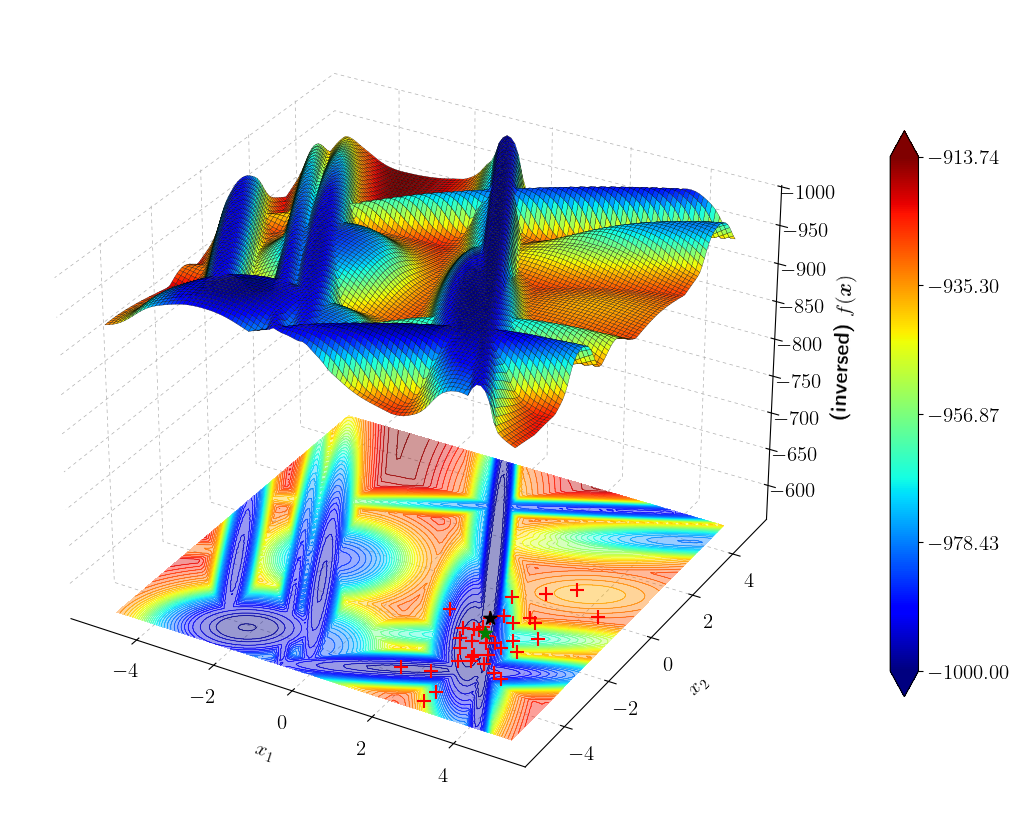

In [14]:
fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    np.array(cma_history),
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)

zax_min, zax_max = ax.get_zlim()
ax.scatter(
    res.xbest[0],
    res.xbest[1],
    zax_min,
    c="black",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
)
ax.scatter(
    res.xfavorite[0],
    res.xfavorite[1],
    zax_min,
    c="green",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
)

In [4]:
from datetime import datetime
from importlib import reload

import FewShotCVRP.bo_pure as bo_pure

reload(bo_pure)

bo = bo_pure.BayesianOptimizer(
    f,
    f_batch=None,
    bounds=[(-5.0, 5.0), (-5.0, 5.0)],
    n_init=10,
    n_iter=20,
    sigma=0.001,
    # noise_std_guess=0.5,
    # noise_std_bounds=(0.1, 1.0),
    kernel="rbf",
    kernel_isotropic=True,
    length_scale_bounds=(0.1, 10.0),
    c_factor_bounds=(1 / 2, 2.0),
    suggestions_per_step=3,  # 3 diverse local maxima of EI per iteration
    diversity_frac=0.1,  # 10% of average box size as min separation
    random_state=1,
)
result = bo.run()
gp = bo.get_gp()
print("Best x:", result["x_obs_best"], "Best y:", result["y_obs_best"])
print("Recommended x:", result["x_rec_mean_global"], "Best y:", result["x_rec_mean_global"])
print("Kernel:", gp.kernel_)
print("\nARD report:")
bo.report_ard()
now = datetime.now()
current_time = now.strftime("%Y-%m-%d-%Hh%Mm%Ss")
bo.save_snapshot(f"../outputs/bo-experiments-{current_time}", result)

Selected 1 new points
Selected 3 new points
Selected 2 new points
Selected 2 new points
Selected 2 new points
Selected 1 new points
Selected 1 new points
Selected 3 new points
Selected 3 new points
Selected 2 new points
Selected 1 new points
Selected 3 new points
Selected 3 new points
Selected 3 new points
Selected 1 new points
Selected 3 new points
Selected 3 new points
Selected 3 new points
Selected 3 new points
Selected 3 new points
Best x: [0.76287899 2.00679997] Best y: -999.9190230846614
Recommended x: [ 2.26307021 -1.93901744] Best y: [ 2.26307021 -1.93901744]
Kernel: 1.09**2 * RBF(length_scale=0.678)

ARD report:
feature    length_scale        1/length
---------------------------------------
x0             0.677975         1.47498
x1             0.677975         1.47498


PosixPath('../outputs/bo-experiments-2025-09-05-11h42m06s')

In [5]:
import FewShotCVRP.bo_pure as bo_pure

snap = bo_pure.BayesianOptimizer.load_snapshot(
    "../outputs/bo-experiments-2025-09-05-11h42m06s"
)

gp = snap.gp
X = snap.arrays["X_"]
y = snap.arrays["y_"]
print("Kernel:", gp.kernel_)
print("Best:", snap.result["x_obs_best"], snap.result["y_obs_best"])
mu, std = gp.predict(X[:3], return_std=True)
print("Posterior @ first 3 points:", mu, std)

Kernel: 1.09**2 * RBF(length_scale=0.678)
Best: [0.7628789917424132, 2.006799974694311] -999.9190230846614
Posterior @ first 3 points: [-933.40872873 -915.43546263 -988.08265403] [0.02521583 0.02521583 0.02521575]


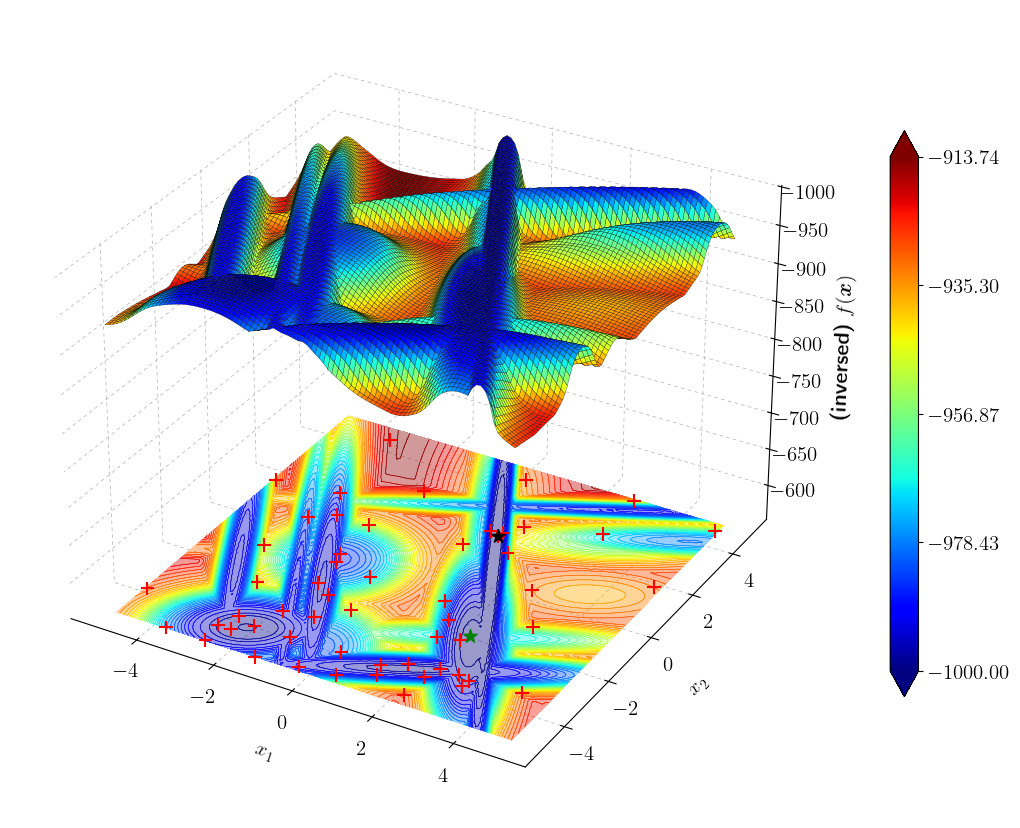

In [6]:
fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    X,
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)

x_obs_best = snap.result["x_obs_best"]
x_rec_mean_global = snap.result["x_rec_mean_global"]
zax_min, zax_max = ax.get_zlim()
ax.scatter(
    x_obs_best[0],
    x_obs_best[1],
    zax_min,
    c="black",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
)
ax.scatter(
    x_rec_mean_global[0],
    x_rec_mean_global[1],
    zax_min,
    c="green",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
)

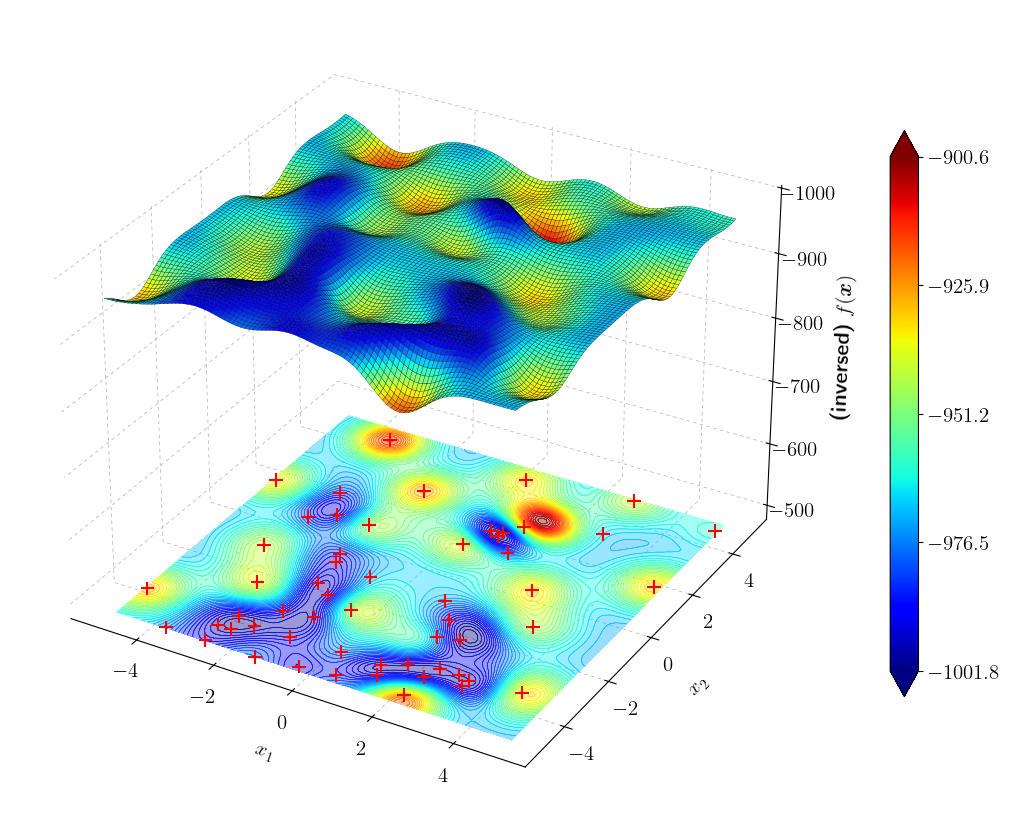

In [7]:
fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    lambda x: gp.predict([x], return_std=False)[0],
    X,
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)

In [ ]:
from datetime import datetime
from importlib import reload

import FewShotCVRP.bo_pure as bo_pure

reload(bo_pure)

bo = bo_pure.BayesianOptimizer(
    f,
    f_batch=None,
    bounds=[(-5.0, 5.0), (-5.0, 5.0)],
    n_init=10,
    n_iter=20,
    sigma=0.001,
    # noise_std_guess=0.5,
    # noise_std_bounds=(0.1, 1.0),
    kernel="matern",
    kernel_isotropic=True,
    length_scale_bounds=(0.1, 10.0),
    c_factor_bounds=(1 / 2, 2.0),
    suggestions_per_step=3,  # 3 diverse local maxima of EI per iteration
    diversity_frac=0.1,  # 10% of average box size as min separation
    random_state=1,
)
result = bo.run()
gp = bo.get_gp()
print("Best x:", result["x_obs_best"], "Best y:", result["y_obs_best"])
print("Recommended x:", result["x_rec_mean_global"], "Best y:", result["x_rec_mean_global"])
print("Kernel:", gp.kernel_)
print("\nARD report:")
bo.report_ard()
now = datetime.now()
current_time = now.strftime("%Y-%m-%d-%Hh%Mm%Ss")
bo.save_snapshot(f"../outputs/bo-experiments-{current_time}", result)

Selected 2 new points
Selected 3 new points
Selected 2 new points
Selected 3 new points
Selected 1 new points
Selected 2 new points
Selected 2 new points
Selected 3 new points
Selected 3 new points
Selected 2 new points
Selected 3 new points
Selected 3 new points
Selected 3 new points
Selected 3 new points
Selected 3 new points
Selected 2 new points
Selected 3 new points
Selected 3 new points
Selected 2 new points
Selected 2 new points
Best x: [ 2.63052754 -2.26237719] Best y: -998.3710744907567
Recommended x: [ 2.27274275 -1.99340973] Best y: [ 2.27274275 -1.99340973]
Kernel: 1.17**2 * Matern(length_scale=0.949, nu=2.5)

ARD report:
feature    length_scale        1/length
---------------------------------------
x0             0.949046         1.05369
x1             0.949046         1.05369


PosixPath('../outputs/bo-experiments-2025-09-05-11h45m25s')

Text(0.5, 0.92, 'GP model of the landscape')

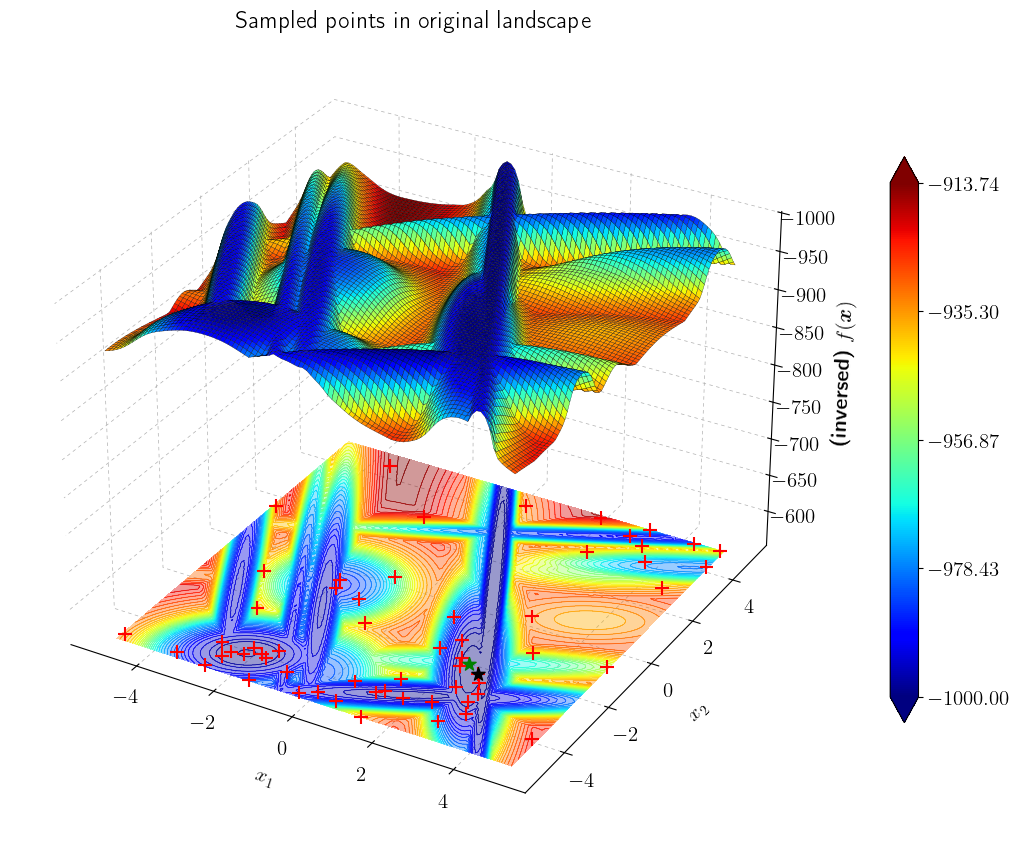

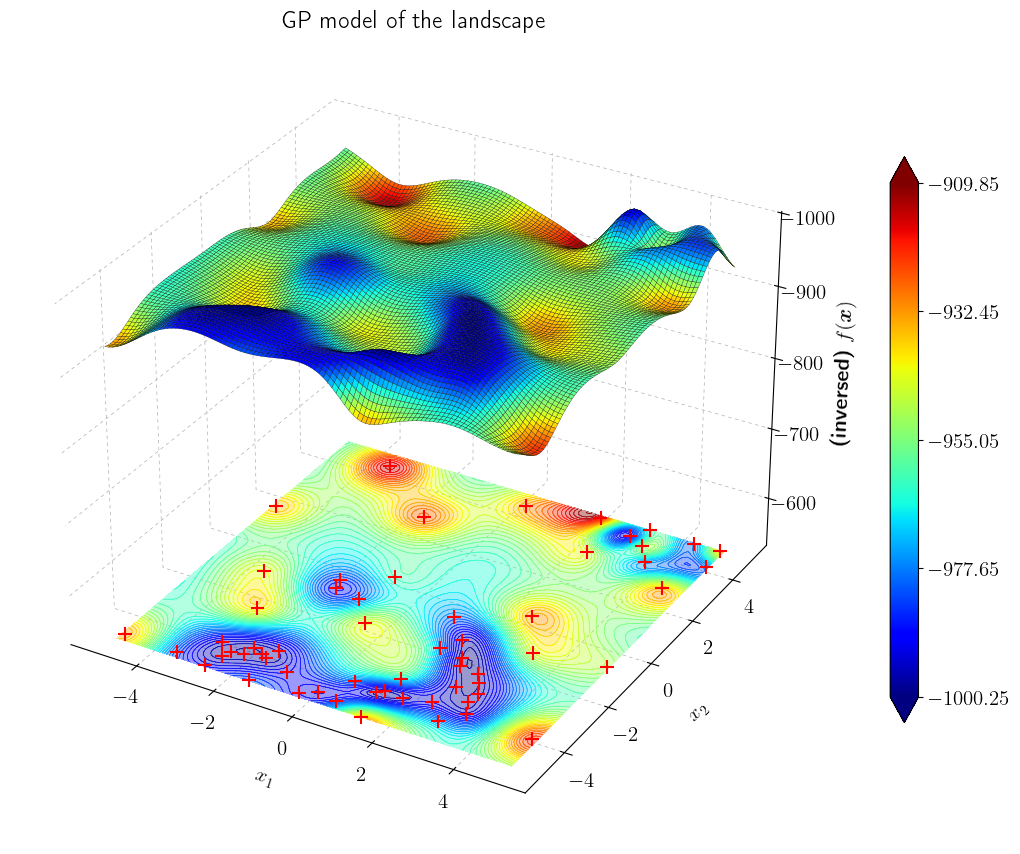

In [10]:
snap = bo_pure.BayesianOptimizer.load_snapshot(
    "../outputs/bo-experiments-2025-09-05-11h45m25s"
)

gp = snap.gp
X = snap.arrays["X_"]
y = snap.arrays["y_"]

fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    X,
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)

x_obs_best = snap.result["x_obs_best"]
x_rec_mean_global = snap.result["x_rec_mean_global"]
zax_min, zax_max = ax.get_zlim()
ax.scatter(
    x_obs_best[0],
    x_obs_best[1],
    zax_min,
    c="black",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
)
ax.scatter(
    x_rec_mean_global[0],
    x_rec_mean_global[1],
    zax_min,
    c="green",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
)

ax.set_title("Sampled points in original landscape")

fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    lambda x: gp.predict([x], return_std=False)[0],
    X,
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)
ax.set_title("GP model of the landscape")

### EI study

In [ ]:
from datetime import datetime
from importlib import reload

from ioh import ProblemClass, get_problem

import FewShotCVRP.bo_pure as bo_pure

reload(bo_pure)



def acq_opt_callback(bo, opt_xs, init_xs, selected_xs):
    fig, ax = myplots.plot_3D_surface(
        (-5, 5),
        (-5, 5),
        bo._ei,
        opt_xs,
        is_axis_names=True,
        is_white_facecolor=True,
        is_colorbar=True,
        discretization=100,
        zfactor=2.0,
        is_inverse=False,
    )
    ax.scatter(
        init_xs[:, 0],
        init_xs[:, 1],
        zax_min,
        c="black",
        marker="*",
        s=100,
        alpha=1,
        zorder=4,
    )
    ax.scatter(
        selected_xs[:, 0],
        selected_xs[:, 1],
        zax_min,
        c="blue",
        marker="o",
        s=100,
        alpha=1,
        zorder=4,
    )



f = get_problem(22, instance=1, dimension=2, problem_class=ProblemClass.BBOB)


bo = bo_pure.BayesianOptimizer(
    f,
    f_batch=None,
    bounds=[(-5.0, 5.0), (-5.0, 5.0)],
    n_init=10,
    n_iter=20,
    sigma=0.001,
    # noise_std_guess=0.5,
    # noise_std_bounds=(0.1, 1.0),
    kernel="rbf",
    kernel_isotropic=True,
    length_scale_bounds=(0.1, 10.0),
    c_factor_bounds=(1 / 2, 2.0),
    suggestions_per_step=10,  # 3 diverse local maxima of EI per iteration
    diversity_frac=0.1,  # 10% of average box size as min separation
    random_state=1,
    acq_opt_callback=acq_opt_callback
)
result = bo.run()
gp = bo.get_gp()
print("Best x:", result["x_obs_best"], "Best y:", result["y_obs_best"])
print(
    "Recommended x:",
    result["x_rec_mean_global"],
    "Best y:",
    result["x_rec_mean_global"],
)
print("Kernel:", gp.kernel_)
print("\nARD report:")
bo.report_ard()
# now = datetime.now()
# current_time = now.strftime("%Y-%m-%d-%Hh%Mm%Ss")
# bo.save_snapshot(f"../outputs/bo-experiments-{current_time}", result)

Selected 1 new points
Selected 3 new points
Selected 2 new points
Selected 2 new points
Selected 2 new points
Selected 1 new points
Selected 1 new points
Selected 3 new points
Selected 3 new points
Selected 2 new points
Selected 1 new points
Selected 3 new points
Selected 5 new points
Selected 3 new points
Selected 1 new points
Selected 2 new points
Selected 4 new points
Selected 6 new points
Selected 3 new points
Selected 2 new points
Best x: [0.34947514 2.62437346] Best y: -999.5413388822478
Recommended x: [-2.37908101 -4.14372014] Best y: [-2.37908101 -4.14372014]
Kernel: 1.05**2 * RBF(length_scale=0.673)

ARD report:
feature    length_scale        1/length
---------------------------------------
x0             0.672634         1.48669
x1             0.672634         1.48669


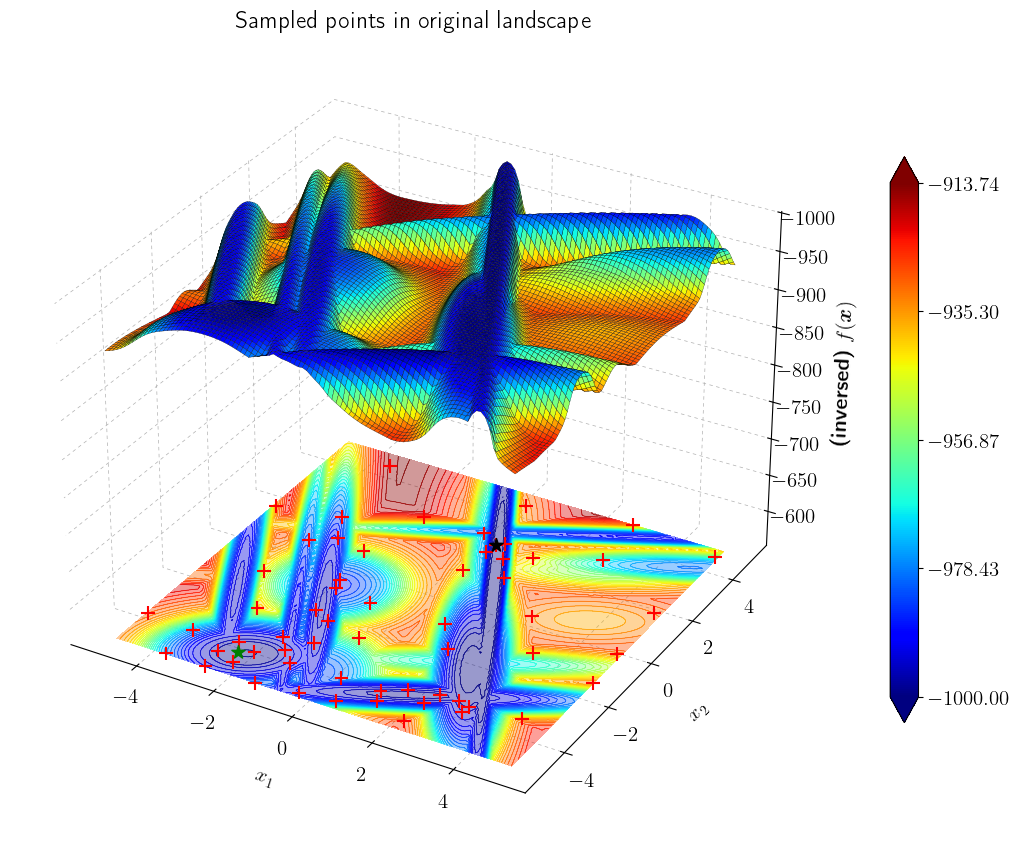

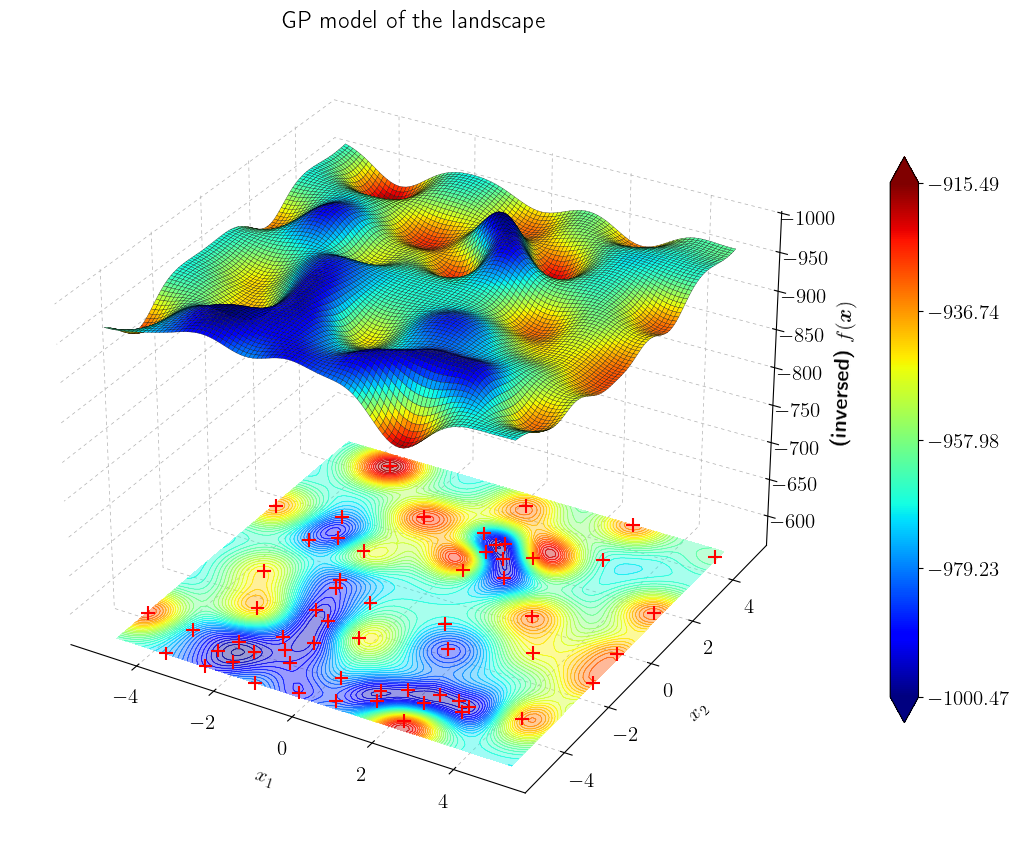

In [13]:
def plot_opt_gp(gp, X, result):
    fig, ax = myplots.plot_3D_surface(
        (-5, 5),
        (-5, 5),
        f,
        X,
        is_axis_names=True,
        is_white_facecolor=True,
        is_colorbar=True,
        discretization=100,
        zfactor=2.0,
        is_inverse=True,
    )

    x_obs_best = result["x_obs_best"]
    x_rec_mean_global = result["x_rec_mean_global"]
    zax_min, zax_max = ax.get_zlim()
    ax.scatter(
        x_obs_best[0],
        x_obs_best[1],
        zax_min,
        c="black",
        marker="*",
        s=100,
        alpha=1,
        zorder=4,
    )
    ax.scatter(
        x_rec_mean_global[0],
        x_rec_mean_global[1],
        zax_min,
        c="green",
        marker="*",
        s=100,
        alpha=1,
        zorder=4,
    )

    ax.set_title("Sampled points in original landscape")

    fig, ax = myplots.plot_3D_surface(
        (-5, 5),
        (-5, 5),
        lambda x: gp.predict([x], return_std=False)[0],
        X,
        is_axis_names=True,
        is_white_facecolor=True,
        is_colorbar=True,
        discretization=100,
        zfactor=2.0,
        is_inverse=True,
    )
    ax.set_title("GP model of the landscape")

plot_opt_gp(bo.get_gp(), bo.X_, result)


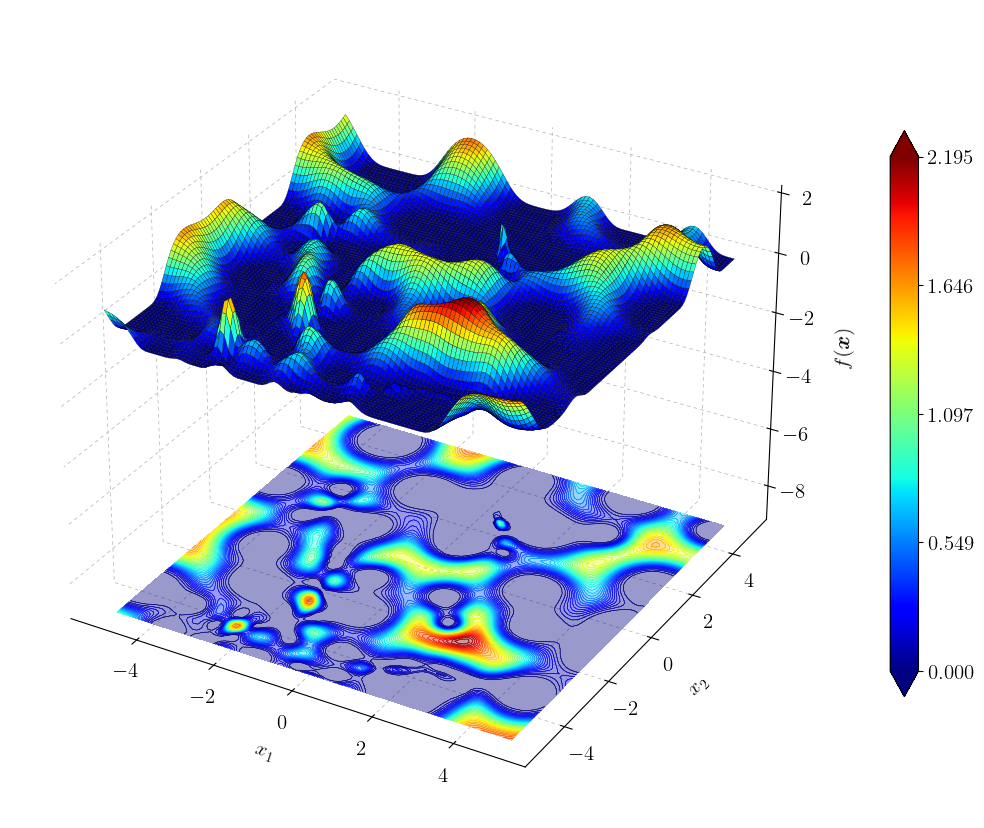

In [19]:
import numpy as np


fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    # lambda x: np.log(bo._ei(x) + 1e-10),
    bo._ei,
    [],
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=False,
)


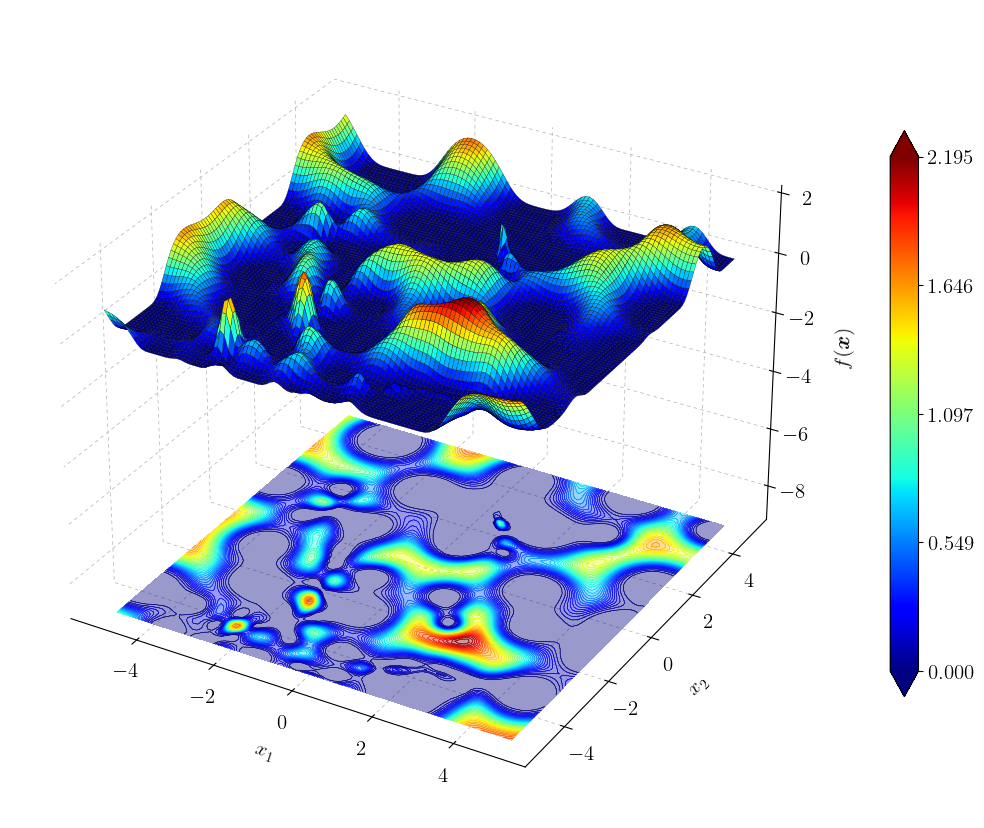

In [ ]:
import numpy as np


fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    # lambda x: np.log(bo._ei(x) + 1e-10),
    bo._ei,
    [],
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=False
)
